# Projekt_1



1. Dane

Wprowadzamy dane, które będziemy analizowali oraz sprawdzam ich przebieg.

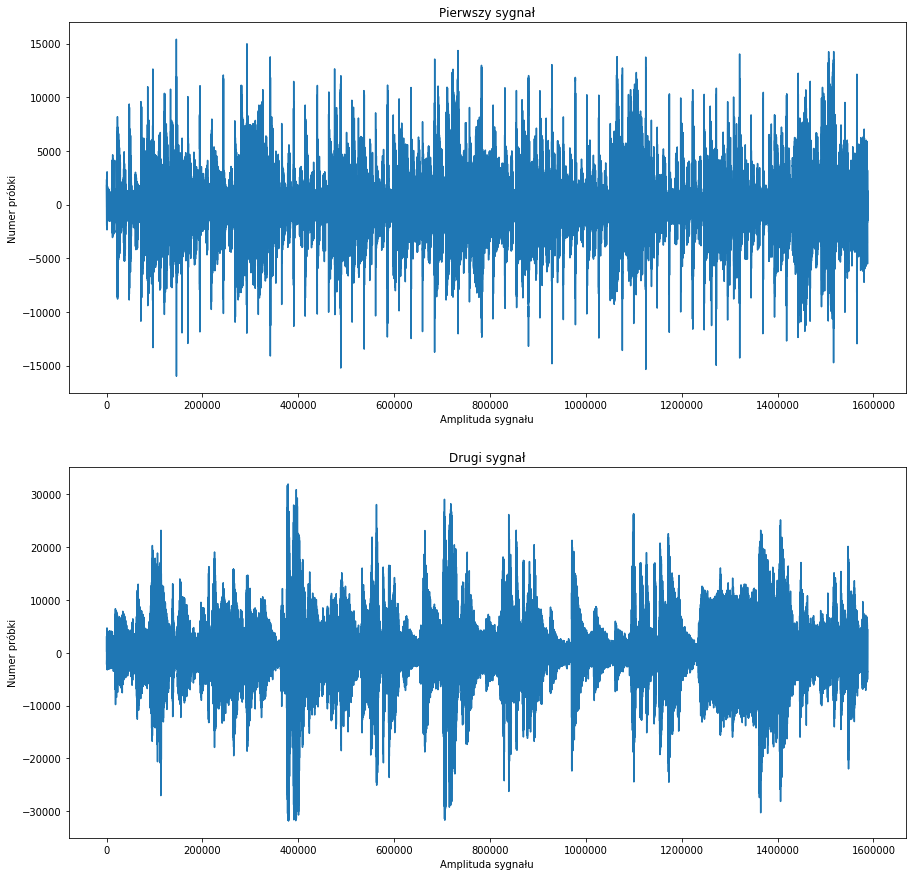

In [13]:
#%matplotlib inline
import matplotlib
import scipy.io.wavfile as wav
import numpy as np
import scipy.signal as ss
import matplotlib.pylab as plt
from matplotlib import gridspec

Fs1, signal1 = wav.read('Candy_Dulfer_-_Lily_Was_Here.wav')

Fs2, signal2 = wav.read('Rupert_Blaise_-_06_-_What_A_Wonderful_World.wav')

plt.subplot(2,1,1)
plt.plot(signal1)
plt.xlabel("Amplituda sygnału")
plt.ylabel("Numer próbki")
plt.title("Pierwszy sygnał")
plt.subplot(2,1,2)
plt.plot(signal2)
plt.xlabel("Amplituda sygnału")
plt.ylabel("Numer próbki")
plt.title("Drugi sygnał")
plt.show()

2. Analiza czasowa widma: spektogram

Tworzę funkcję periodogram pozwalającą na wyestymowanie widma gęstości energii z danym okienkiem, która zwraca widmo mocy oraz skalę mocy częstości.

In [16]:
def periodogram(signal, okno, Fs):
    s = signal
    okno = okno / np.linalg.norm(okno) 
    s = s*okno 
    S = np.fft.rfft(s) 
    P = S*S.conjugate()      
    P = P/Fs
    P = P.real 
    if len(s)%2 == 0: 
        P[1:-1] *= 2
    else:
        P[1:] *= 2
    F = np.fft.rfftfreq(len(s),1.0/Fs) 
    return F, P


Tworzę funkcję wytwarzającą spektogram dla danego sygnału. Badany sygnał okienkujemy za pomocą okien o długości N_okna, które mogą na siebie zachodzić w pewnym stopniu (N_wsp). Potrzebujemy dwóch okienek - okno_1, które wykorzystujemy do zokienkowania sygnału, dla którego tworzymy spektrogram, oraz okno_2, które posłuży nam do policzenia periodogramu badanego sygnału bez podziału go na fragmenty, aby móc zaobserwować widmo gęstości mocy sygnału. Typy okien będą takie same, zmienią się ich długości - w przypadku okno_2 nie uwzględniamy nachodzenia i bierzemy długość okna równą długości sygnału - dlatego jeżeli analizujemy tylko fragment sygnału, musimy podać długość okna jako różnicę indeksów, które są granicami badanego fragmentu sygnału. W przypadku czasu i częstości, ustawiam domyślne t_max jako długość całego sygnału, z uwzględnieniem, że gdy podajemy wartość czasu spoza skali, funkcja pobiera domyślną wartość. Tak samo w przypadku częstości - domyślną wartość max ustalama jako częstość Nyquista.

In [103]:
def spektrogram(s,okno_1,Fs, N_okna,N_wsp=0,t_min=0,t_max=0,f_min=0,f_max=0):
    
    #zaczynam od znalezienia liczby okienek, a tym samym długości sygnału na której pracujemy
    
    N_W = N_wsp*N_okna #liczba punktów okienka, które zachodzą na siebie
    liczba_okienek= int((len(s)-N_W)//(N_okna-N_W))# odcinam ostatni fragment nachodzących na siebie okienek i sprawdzam ile fragmentów o długości "N_okna - N_W" mieści się w sygnale
    
    #przypisuję wartością czasu i częstości domyślnie max i min wartości, w przypadku podania wartości spoza skali lub nie podania ich wcale
    if t_max==0 or t_max > (liczba_okienek*N_okna)/Fs:
        t_max = len(s)/Fs
    if f_max==0:
        f_max = Fs/2
        
    #sprawdzam ile wartości częstości otrzymujemy po wykonaniu transformaty Fouriera, a by móc stworzyć macierz spektrogramu, tak aby i-ta kolumna zawierała widmo i-tego fragmentu
    #Wartości te zostaną pobrane z periodogramu i dodane do macierzy spektrogramu, dlatego musi mieć ona wymiary "liczba wartości częstości"x"ilość_okienek"
        
    n = int(N_okna/2 +1) #n zależne jest od parzystości długości okna, które stosujemy, dlatego uwzględniamy przypadek, gdy okno jest nieparzyste
    if N_okna%2 !=0:
        n = int((N_okna-1)/2 +1)
        
    #tworzę macierz spektrogramu i dodaję do niej odpowiednie wartości P pobrane z periodogramu 
    spektrogram = np.zeros((n,liczba_okienek))
    i =0
    for j in range(0, liczba_okienek):
        s1 = s[int(i):int(i+N_okna)]
        i= i+N_okna - N_W
        F, P = periodogram(s1,okno_1,Fs)
        spektrogram[:,j]=P
       
    
    #przekształcam podane argumenty czasu na indeksy, które potem wykorzystam w periodogramie dla widma gęstości mocy 
    index_t_min=round(t_min*Fs)
    index_t_max=round(t_max*Fs)
    T_min= index_t_min/Fs  #zaokrąglenie podanego czasu do najbliższej wartości występującej w tablicy t (występują tam co dt = 1/Fs)
    T_max= index_t_max/Fs
    t=np.arange(T_min,T_max,1.0/Fs)
    

    spektrogram = 20*np.log10(spektrogram) #skala dB
    spektrogram=spektrogram[round(f_min/Fs*N_okna):round(f_max/Fs*N_okna),round(index_t_min/N_okna):round(index_t_max/N_okna)]
    
    #Wykresy
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2], height_ratios=[4, 1],wspace=0.5,hspace=0.5)
    ax1 = plt.subplot(gs[0])
    
    #widmo gęstości mocy bez podziału sygnału na fragmenty
    okno_2 = ss.hamming(index_t_max-index_t_min)
    F_2, P_2 = periodogram(s[index_t_min:index_t_max],okno_2,Fs)
    ax1.plot(P_2,F_2)
    plt.title("Widmo gęstości mocy sygnału")
    plt.xlabel('Moc P [V^2/Hz]')
    plt.ylabel("Częstość f [Hz]")
    ax2 = plt.subplot(gs[1])
    
    #spektrogram
    ax2.imshow(spektrogram,extent=(t_min, t_max, f_min, f_max),aspect='auto',origin='lower')
    plt.xlabel("Czas t [s]")
    plt.ylabel("Częstość f [Hz]")
    ax4 = plt.subplot(gs[3])
    
    #zależność mocy sygnału od czasu
    power = np.zeros(len(s))
    for i in range(len(s)):
        power[i]=s[i]**2
    power = power[index_t_min:index_t_max]/Fs
    ax4.plot(t,power)
    plt.title("Moc sygnału w czasie")
    plt.ylabel("Moc P [V^2/Hz]")
    plt.xlabel("Czas t [s]")
    plt.show()
    
    print("Długość okna:",len(okno_1))
    print("Długość sygnału:",len(okno_2))
    print("Stopień nachodzenia okienek:",N_wsp)

Wytwarzam cały spektogram dla pierwszego sygnału

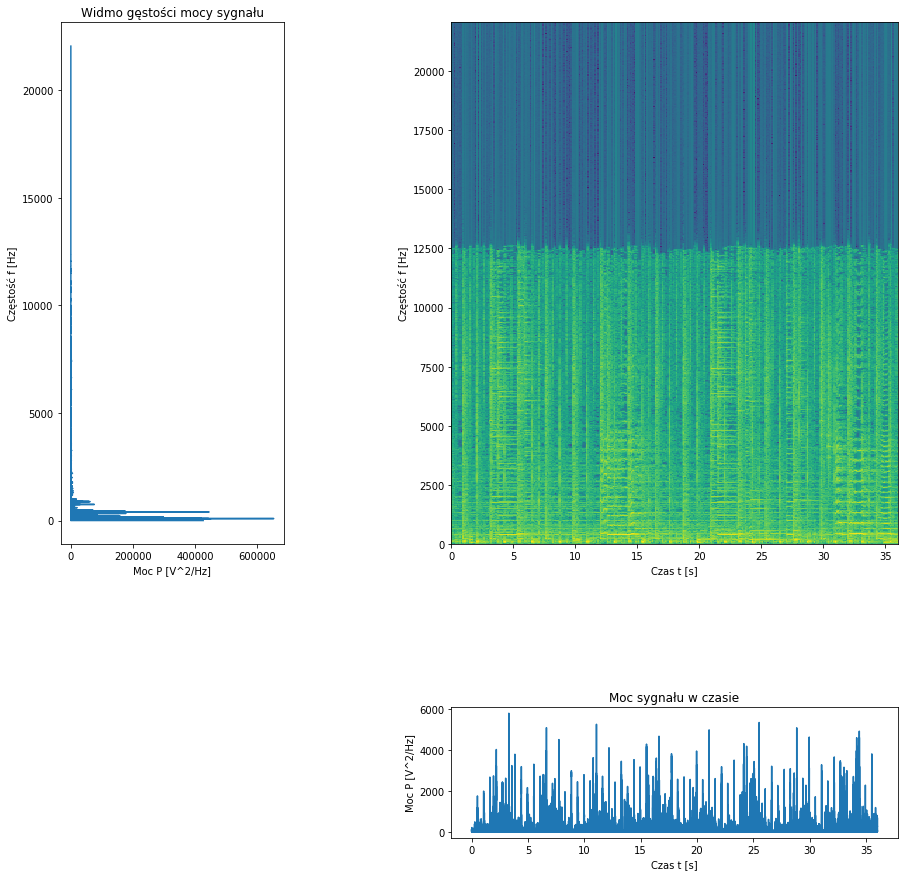

Długość okna: 5000
Długość sygnału: 1587600
Stopień nachodzenia okienek: 0.5


In [104]:
matplotlib.rcParams['figure.figsize'] = (15,15)
N_okna1=5000
okno = ss.hamming(N_okna1)
t_min=0
t_max = 0
N_wsp1 = 0.5
spektrogram(signal1,okno_1 = okno, Fs = Fs1,N_okna = N_okna1,N_wsp = N_wsp1,t_min=t_min,t_max=t_max)


Cały spektrogram dla drugiego sygnału:

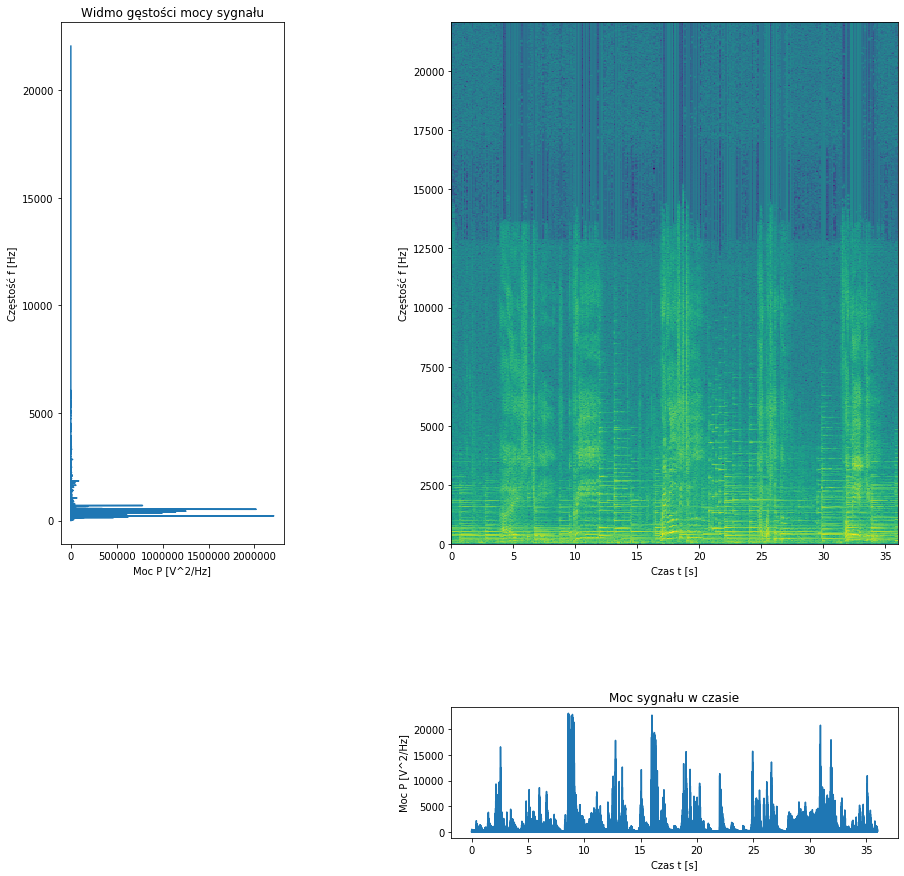

Długość okna: 5000
Długość sygnału: 1587600
Stopień nachodzenia okienek: 0.5


In [69]:
N_okna2=5000
okno = ss.hamming(N_okna2)
t_min=0
t_max = 0
N_wsp1 = 0.5
spektrogram(signal2,okno_1 = okno, Fs = Fs2,N_okna = N_okna1,N_wsp = N_wsp1,t_min=t_min,t_max=t_max)

Widzimy, że dla obu sygnałów częstotliwość graniczna wynosi około 12,5kHz, dlatego też w kolejnych działaniach będę operowała na częstościach poniżej tej granicy.

Sprawdźmy jak wygląda spektrogram, w zależności od długości okna i stopnia nachodzenia na siebie okien. Ciężko zbadać dwie zależności na raz, więc w pierwszej kolejności zobaczmy co się dzieje dla zmiennej długości okienka, ale dla stałego stopnia nachodzenia okienek na siebie, używając pierwszego sygnału. Sprawdzę różnice w spektrogramach dla trzech długości okienek: 10000,5000 i 1000. Będę działać na małych f_max - około 500 - aby zobaczyć jak najlepiej różnice między spektrogramami i wpływ zmian okienkowania na zależność czas - częstość.

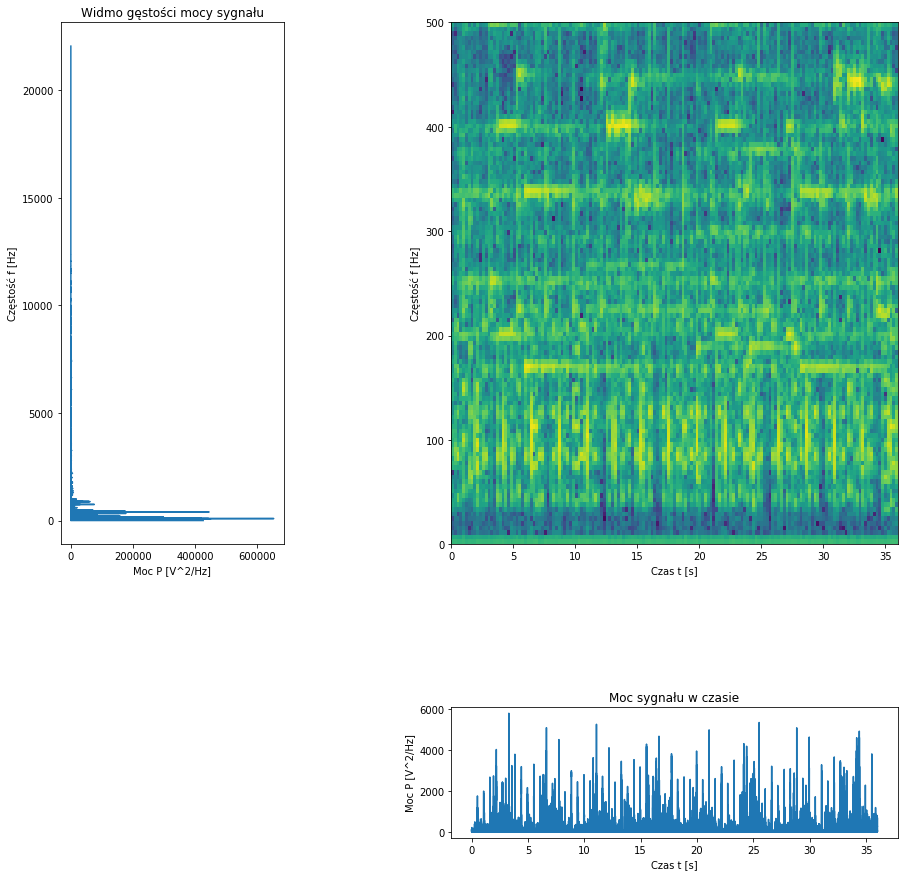

Długość okna: 10000
Długość sygnału: 1587600
Stopień nachodzenia okienek: 0.5


In [77]:
N_okna1_1=10000
okno = ss.hamming(N_okna1_1)
t_min=0
t_max = 0
N_wsp1 = 0.5
spektrogram(signal1,okno_1 = okno, Fs = Fs1,N_okna = N_okna1_1,N_wsp = N_wsp1,f_max=500,t_min=t_min,t_max=t_max)

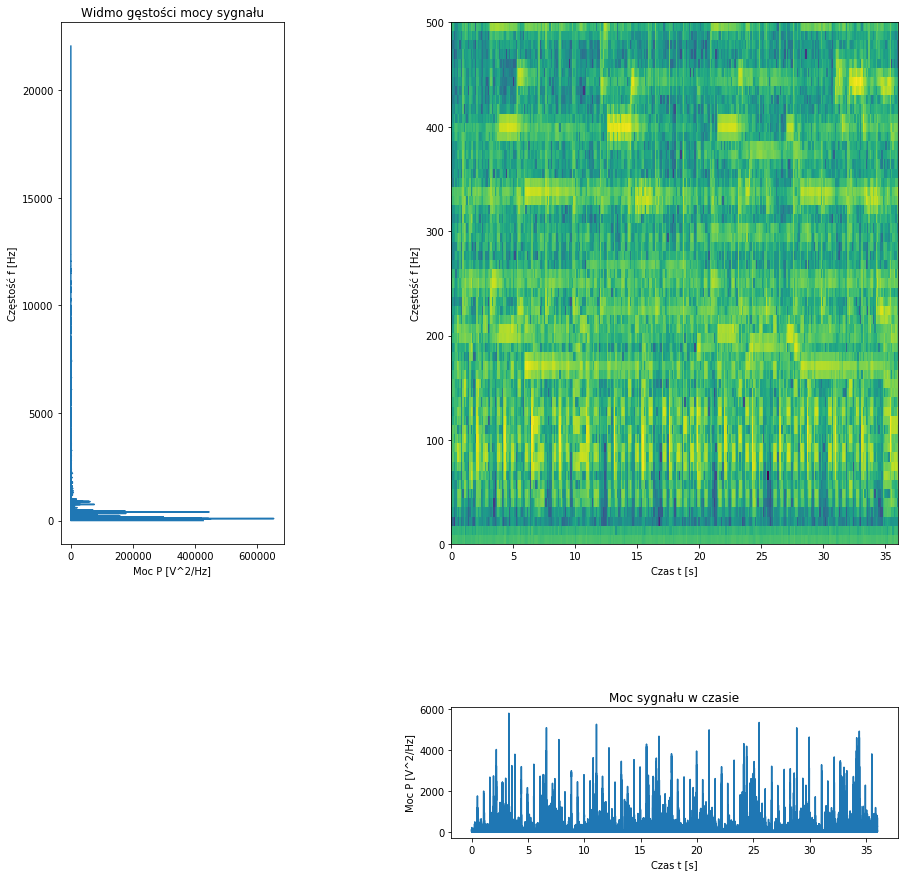

Długość okna: 5000
Długość sygnału: 1587600
Stopień nachodzenia okienek: 0.5


In [78]:
N_okna1_2=5000
okno = ss.hamming(N_okna1_2)
t_min=0
t_max = 0
N_wsp1 = 0.5
spektrogram(signal1,okno_1 = okno, Fs = Fs1,N_okna = N_okna1_2,N_wsp = N_wsp1,f_max=500,t_min=t_min,t_max=t_max)

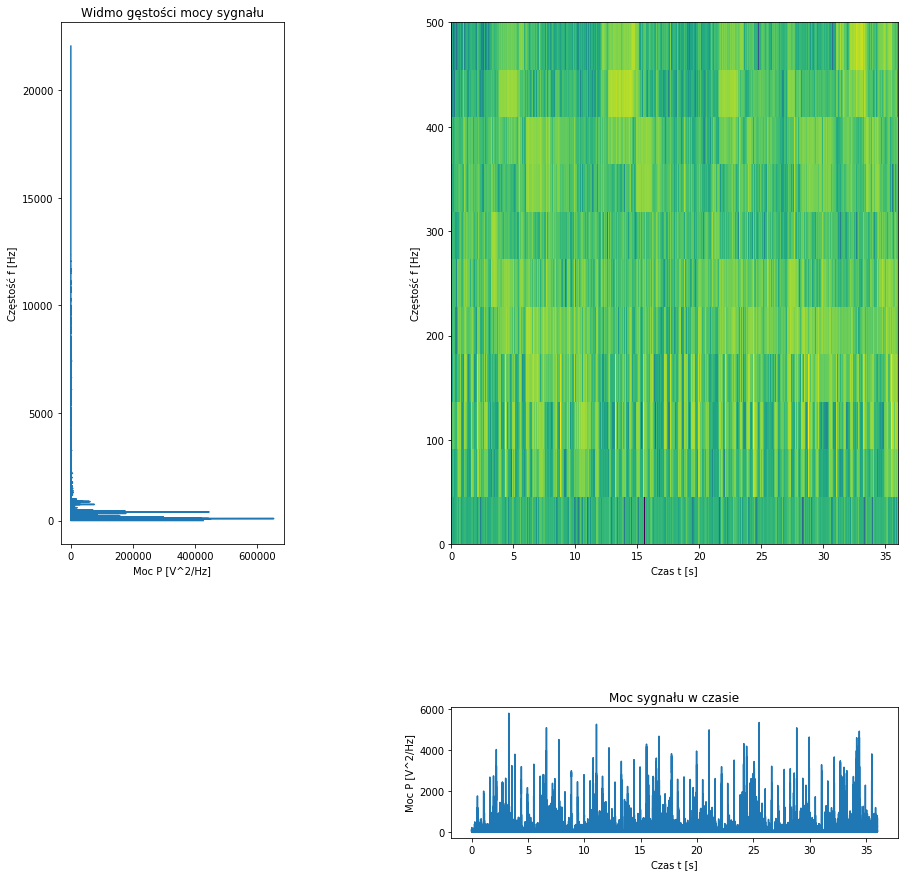

Długość okna: 1000
Długość sygnału: 1587600
Stopień nachodzenia okienek: 0.5


In [79]:
N_okna1_3=1000
okno = ss.hamming(N_okna1_3)
t_min=0
t_max = 0
N_wsp1 = 0.5
spektrogram(signal1,okno_1 = okno, Fs = Fs1,N_okna = N_okna1_3,N_wsp = N_wsp1,f_max=500,t_min=t_min,t_max=t_max)

Teraz zbadajmy jak zmienia się spektrogram w zależności od stopnia nachodzenia na siebie okienek dla pierwszego sygnału.Sprawdzę różnice w spekrogramach dla wartości nachodzenia: 0.9, 0.5, 0.

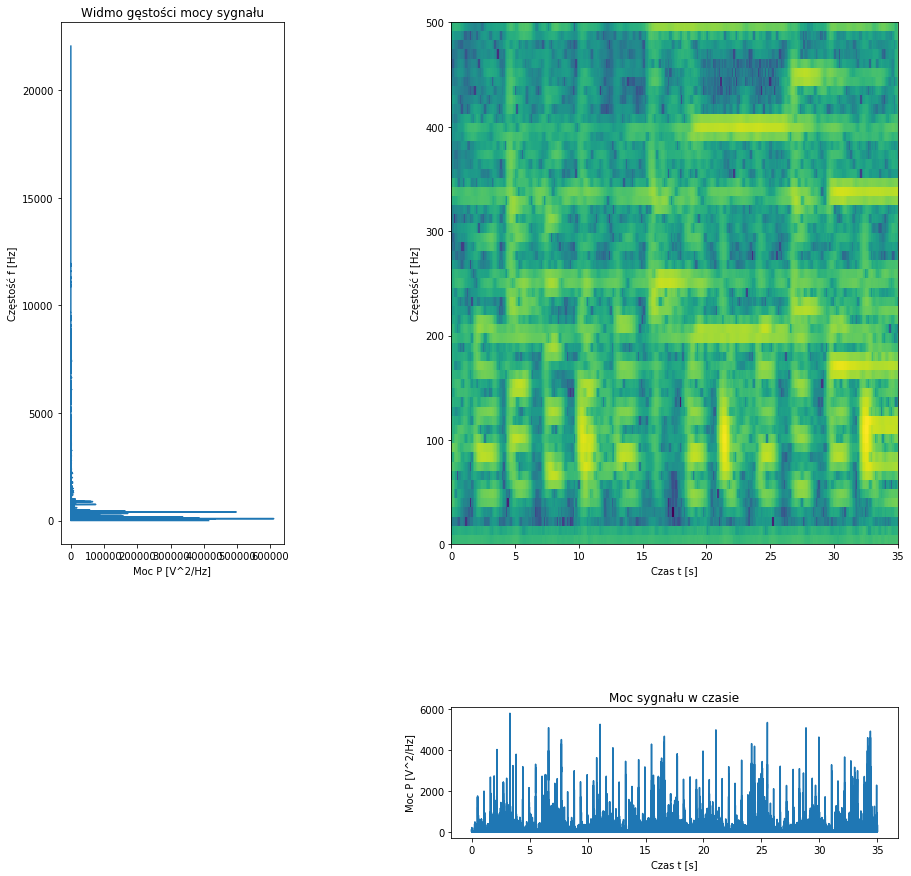

Długość okna: 5000
Długość sygnału: 1543500


In [62]:
N_okna1=5000
okno = ss.hamming(N_okna1)
t_min=0
t_max = 0
N_wsp1_1 = 0.9
spektrogram(signal1,okno_1 = okno, Fs = Fs1,N_okna = N_okna1,N_wsp = N_wsp1_1,f_max=500,t_min=t_min,t_max=t_max)

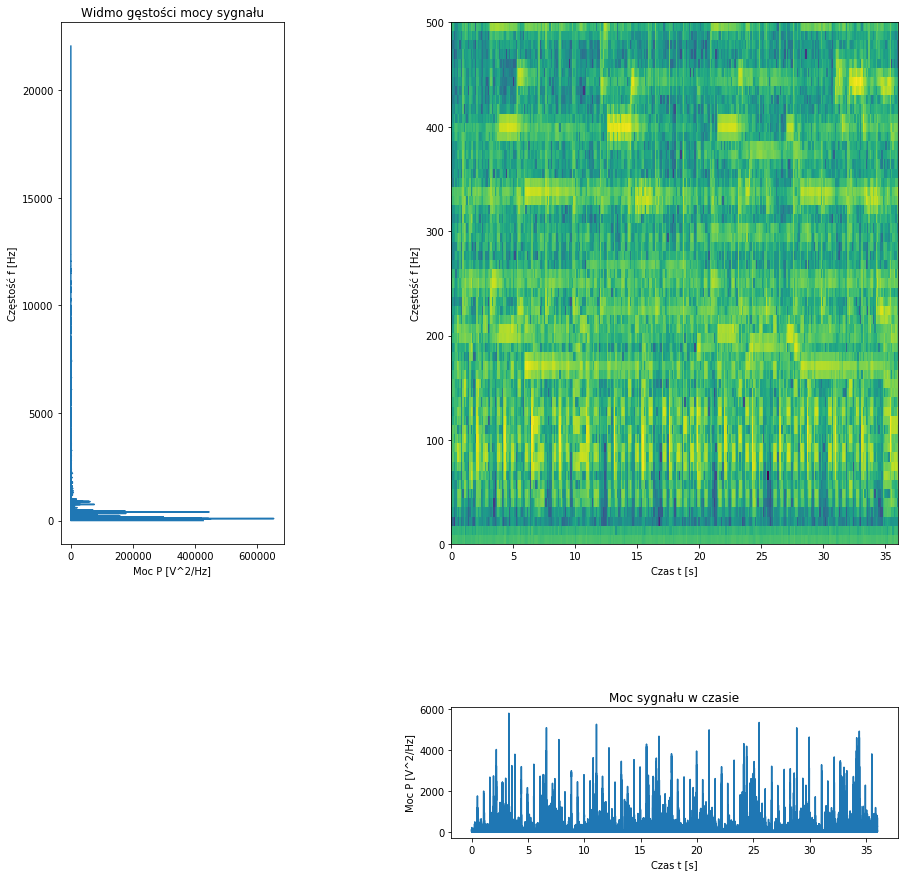

Długość okna: 5000
Długość sygnału: 1587600
Stopień nachodzenia okienek: 0.5


In [82]:
N_okna1=5000
okno = ss.hamming(N_okna1)
t_min=0
t_max = 0
N_wsp1_2 = 0.5
spektrogram(signal1,okno_1 = okno, Fs = Fs1,N_okna = N_okna1,N_wsp = N_wsp1_2,f_max=500,t_min=t_min,t_max=t_max)

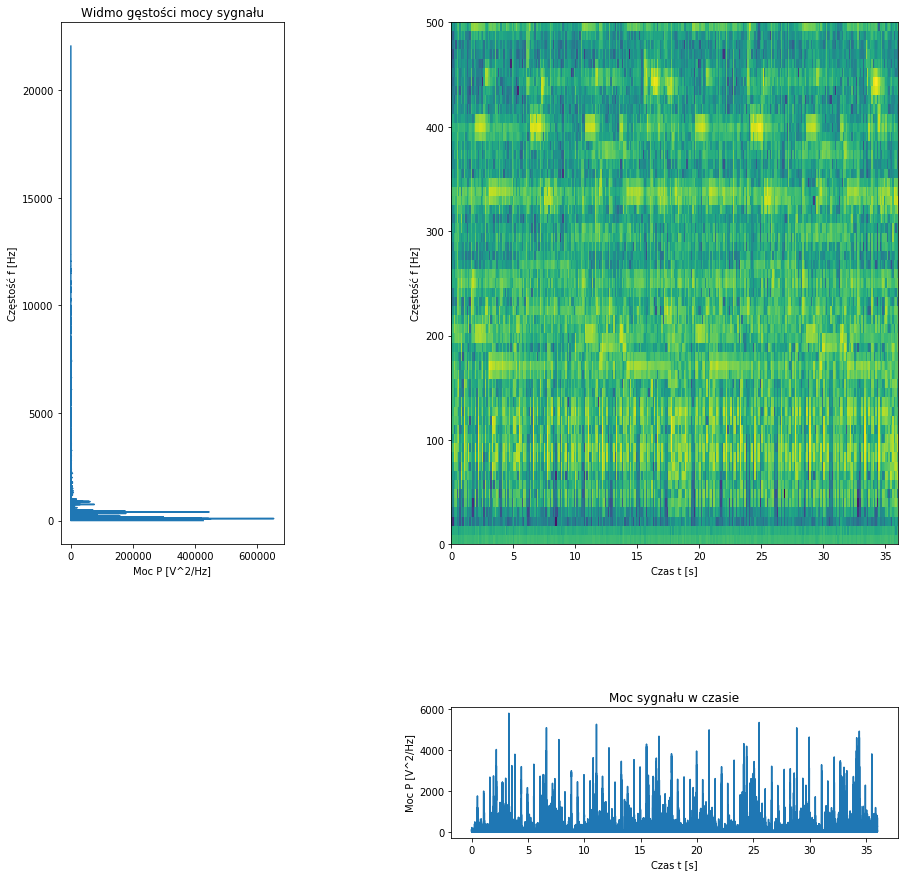

Długość okna: 5000
Długość sygnału: 1587600
Stopień nachodzenia okienek: 0


In [81]:
N_okna1=5000
okno = ss.hamming(N_okna1)
t_min=0
t_max =0
N_wsp1_3 = 0
spektrogram(signal1,okno_1 = okno, Fs = Fs1,N_okna = N_okna1,N_wsp = N_wsp1_3,f_max=500,t_min=t_min,t_max=t_max)

Powtórzmy te działania dla drugiego sygnału.

Ponownie zaczynamy od zmiany długości okienka.

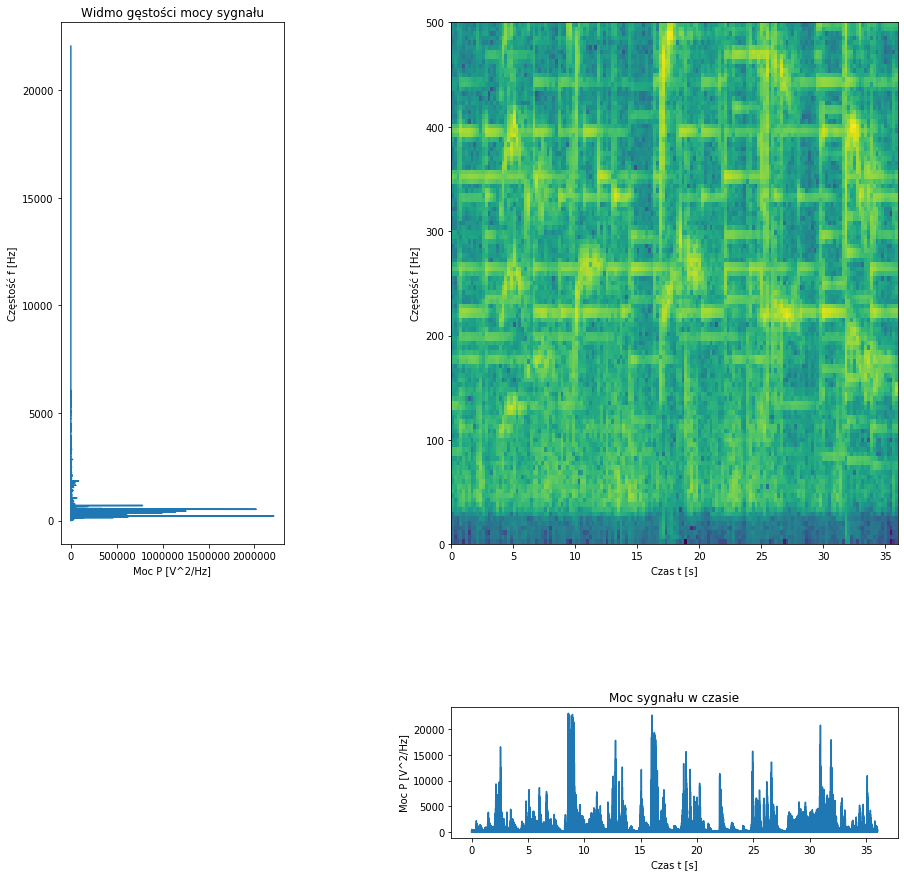

Długość okna: 10000
Długość sygnału: 1587600
Stopień nachodzenia okienek: 0.5


In [80]:
N_okna2_1=10000
okno = ss.hamming(N_okna2_1)
t_min=0
t_max = 0
N_wsp2 = 0.5
spektrogram(signal2,okno_1 = okno, Fs = Fs2,N_okna = N_okna2_1,N_wsp = N_wsp2,f_max=500,t_min=t_min,t_max=t_max)

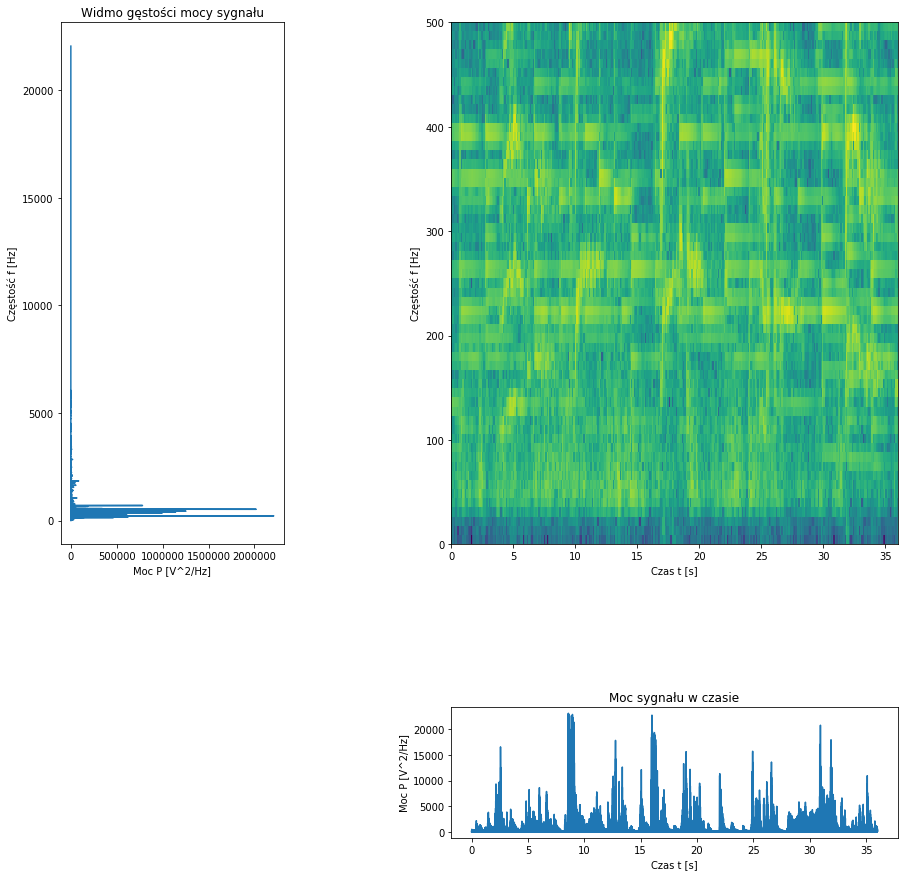

Długość okna: 5000
Długość sygnału: 1587600
Stopień nachodzenia okienek: 0.5


In [83]:
N_okna2_2=5000
okno = ss.hamming(N_okna2_2)
t_min=0
t_max = 0
N_wsp2 = 0.5
spektrogram(signal2,okno_1 = okno, Fs = Fs2,N_okna = N_okna2_2,N_wsp = N_wsp2,f_max=500,t_min=t_min,t_max=t_max)

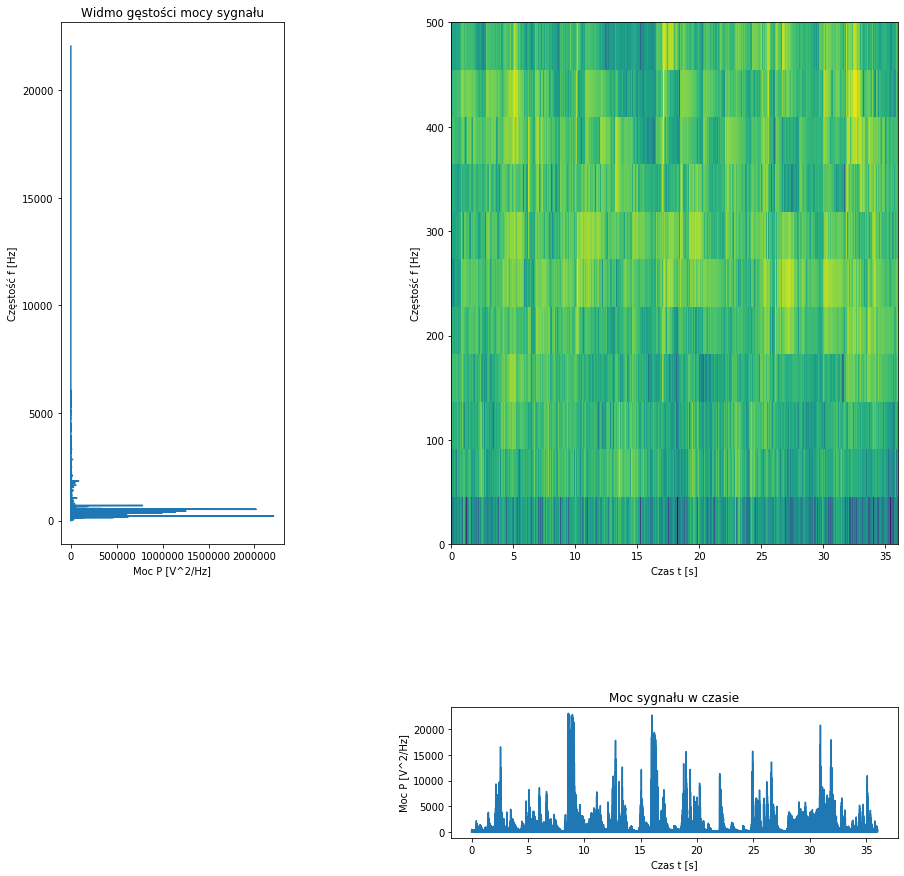

Długość okna: 1000
Długość sygnału: 1587600
Stopień nachodzenia okienek: 0.5


In [84]:
N_okna2_3=1000
okno = ss.hamming(N_okna2_3)
t_min=0
t_max = 0
N_wsp2 = 0.5
spektrogram(signal2,okno_1 = okno, Fs = Fs2,N_okna = N_okna2_3,N_wsp = N_wsp2,f_max=500,t_min=t_min,t_max=t_max)

Zamiana stopnia nachodzenia.

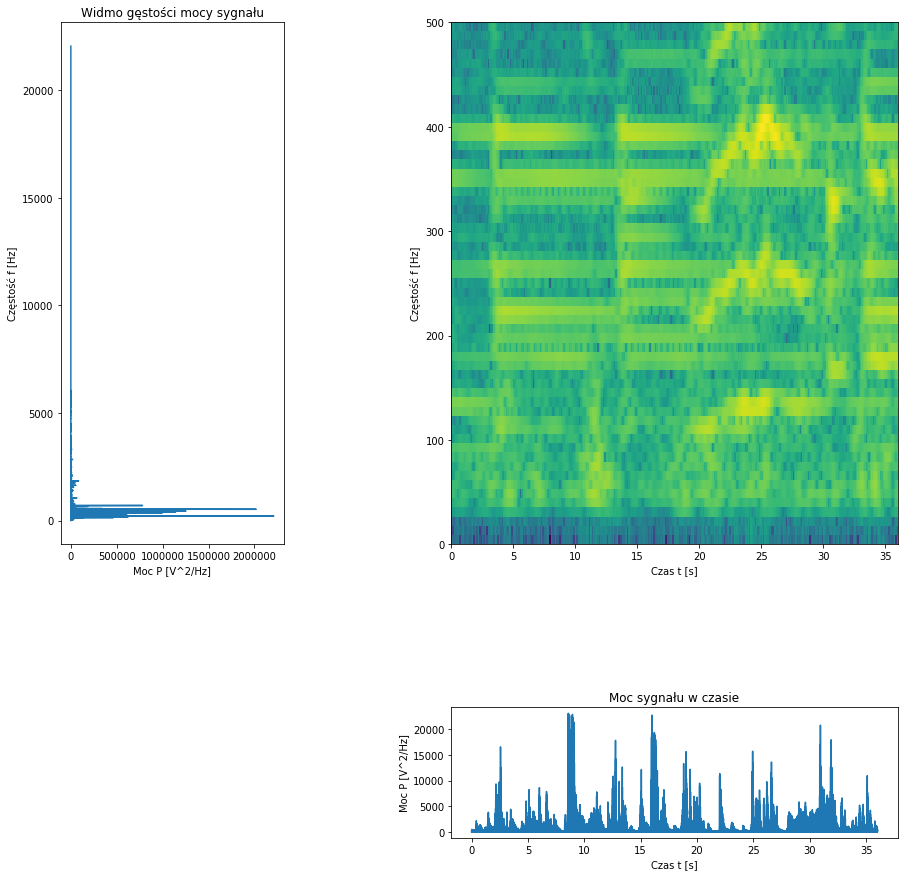

Długość okna: 5000
Długość sygnału: 1587600
Stopień nachodzenia okienek: 0.9


In [85]:
N_okna2=5000
okno = ss.hamming(N_okna2)
t_min=0
t_max =0
N_wsp2_1 = 0.9
spektrogram(signal2,okno_1 = okno, Fs = Fs2,N_okna = N_okna2,N_wsp = N_wsp2_1,f_max=500,t_min=t_min,t_max=t_max)

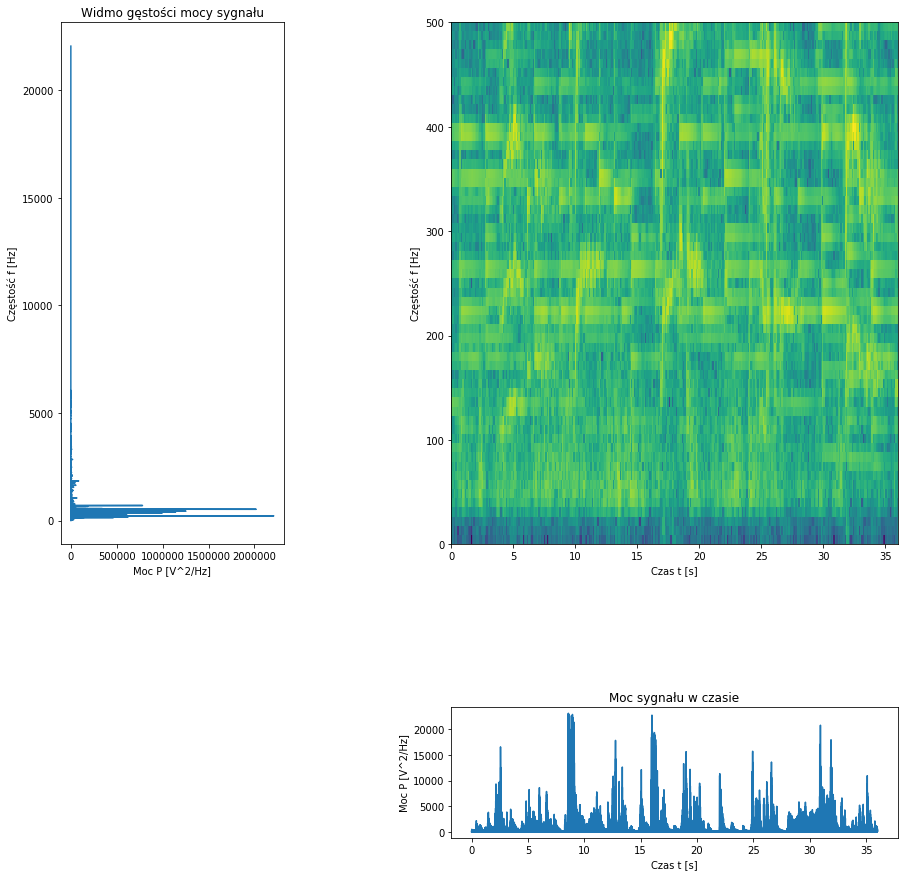

Długość okna: 5000
Długość sygnału: 1587600
Stopień nachodzenia okienek: 0.5


In [88]:
N_okna2=5000
okno = ss.hamming(N_okna2)
t_min=0
t_max =0
N_wsp2_2 = 0.5
spektrogram(signal2,okno_1 = okno, Fs = Fs2,N_okna = N_okna2,N_wsp = N_wsp2_2,f_max=500,t_min=t_min,t_max=t_max)

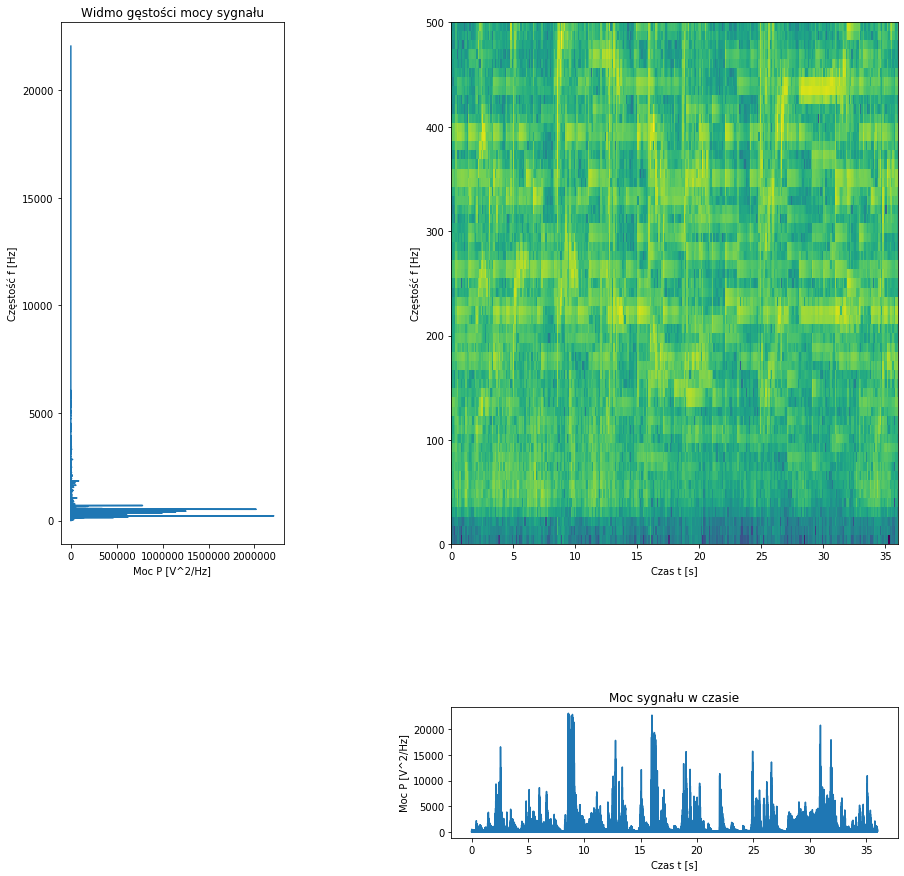

Długość okna: 5000
Długość sygnału: 1587600
Stopień nachodzenia okienek: 0


In [89]:
N_okna2=5000
okno = ss.hamming(N_okna2)
t_min=0
t_max =0
N_wsp2_3 = 0
spektrogram(signal2,okno_1 = okno, Fs = Fs2,N_okna = N_okna2,N_wsp = N_wsp2_3,f_max=500,t_min=t_min,t_max=t_max)

Wyraźnie widać, że zarówno zmiana długości okna jak i stopnia nachodzenia ich na siebie, zmienia nam wygląd spektrogramu. Razem ze wzrostem długości okna, wzrasta jego dokładność w dziedzinie częstości, jednak tracimy na dokładności w dziedzinie czasu - zmniejszamy odległości pomiędzy kolejnymi częstościami, ale za to zwiększamy wartość dt. Wzrost stopnia nachodzenia na siebie okienek, powoduje za to wzrost dokładności w dziedzinie czasu - mamy więcej przedziałów czasu, co za to wpływa na czas analizy. Stopień nachodzenia na siebie okienek nie wpływa na rozdzielczość czasową.

Spróbuję teraz rozpoznać poszczególne instrumenty za pomocą spektrogramu. Po przesłuchaniu pierwszego utworu, jestem wstanie stwierdzić, że instrumentami, które na pewno pojawiają się w utworze są perkusja, gitara oraz saksofon, które wytwarzają dźwięki w zakresach odpowiednio: 60 Hz do 4000 Hz,80 Hz do 1300 Hz, 30Hz do 1600 kHz. Z widma gęstości mocy sygnału wynika, że największy wkład dają częstości do 1000 Hz, dlatego takie f_max wykorzystam w następnych krokach.

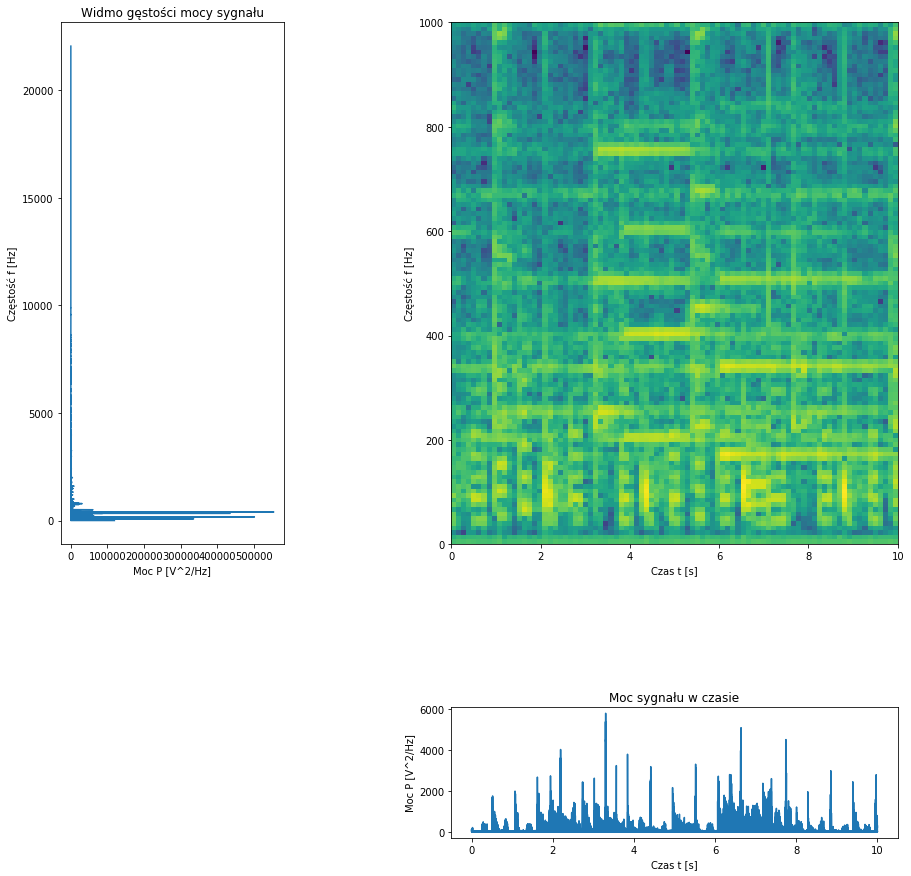

Długość okna: 5000
Długość sygnału: 441000
Stopień nachodzenia okienek: 0.5


In [93]:
N_okna1=5000
okno = ss.hamming(N_okna1)
t_min=0
t_max =10
N_wsp1 = 0.5
spektrogram(signal1,okno_1 = okno, Fs = Fs1,N_okna = N_okna1,N_wsp = N_wsp1,f_max=1000,t_min=t_min,t_max=t_max)

Niestety nie jestem w stanie jednoznacznie powiedzieć, kiedy grał który instrument opierając się jedynie na spektrogramie. Mogę jedynie zgadywać, w którym momencie jakiś instrument zaczął grać, zmieniając tym samym częstotliwość sygnału i wygląd spektrogramu.

W drugim utworze możemy wyróżnić fortepian (28 Hz do ok 4200 Hz) oraz głos osoby śpiewającej. Próbując rozróżnić ich wkład w spektrogram, musimy pamiętać, że fortepian jest w stanie wydobyć z siebie częstotliwości harmoniczne, oraz że grane może być kilka dzwięków na raz, co wpływa na odczytywaną częstotliwość. Człowiekowi o wiele trudniej jest wydobyć z siebie dźwięk o częstotliwości harmonicznej, dlatego uważam, że właśnie na tę różnicę musimy zwrócić szczególną uwagę.

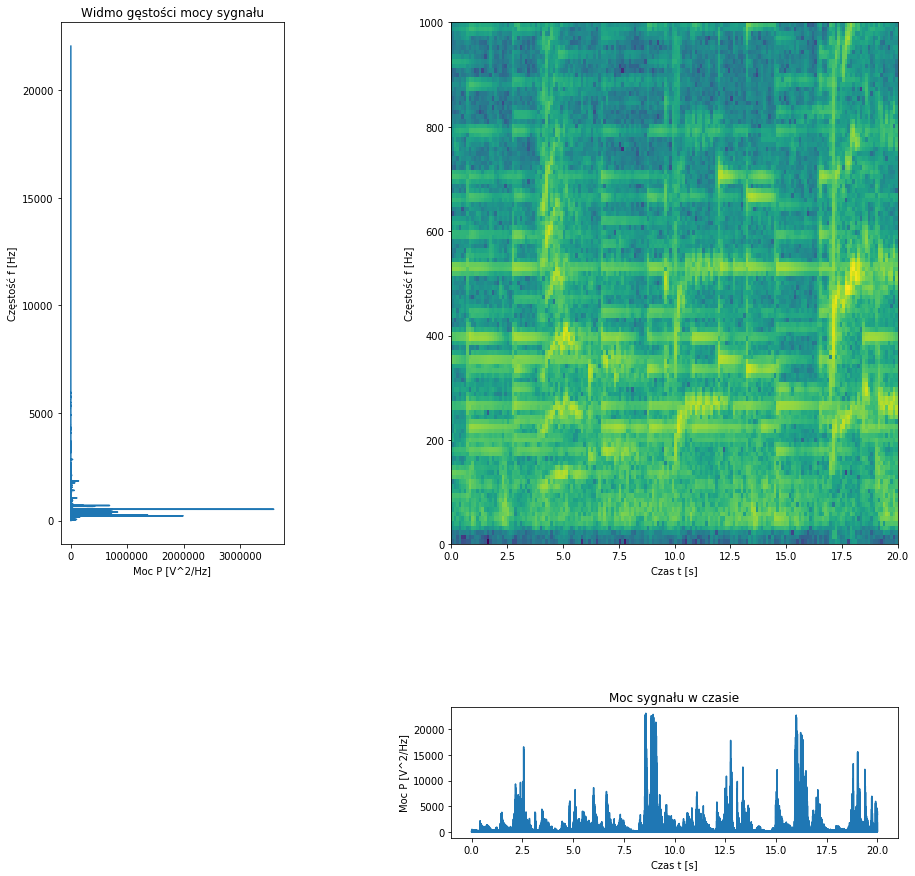

Długość okna: 5000
Długość sygnału: 882000
Stopień nachodzenia okienek: 0.5


In [96]:
N_okna2=5000
okno = ss.hamming(N_okna2)
t_min=0
t_max =20
N_wsp2 = 0.5
spektrogram(signal2,okno_1 = okno, Fs = Fs2,N_okna = N_okna2,N_wsp = N_wsp2,f_max=1000,t_min=t_min,t_max=t_max)

Patrząc na otrzymany spektrogram, założyłabym, że głos ludzki pojawia się około 5 czy 18 sekundy, kiedy widzimy wyraźnie rozmyte pasma. Fortepian natomiast jest zapewne reprezentowany przez wyraźniejsze i "ostrzejsze" linie rozciągające się przez cały spektrogram. 

Spróbujmy teraz wyróżnić tony podstawowe, czyli najniższe tony dźwięku szeregu harmonicznego - inaczej fale harmoniczne o najmniejszej częstotliwości w szeregu harmonicznym. Sprawdźmy więc tylko drugi utwór, gdzie łatwiej jest wyodrębnić fragmenty z pojedynczymi instrumentami. Zobaczmy jak wygląda spektrogram dla czasu 10 - 12s, kiedy słyszymy tylko fortepian, oraz w okolicach 28 sekundy, kiedy piosenkarz wydobywa z siebie wyjątkowo czysty, wysoki głos.

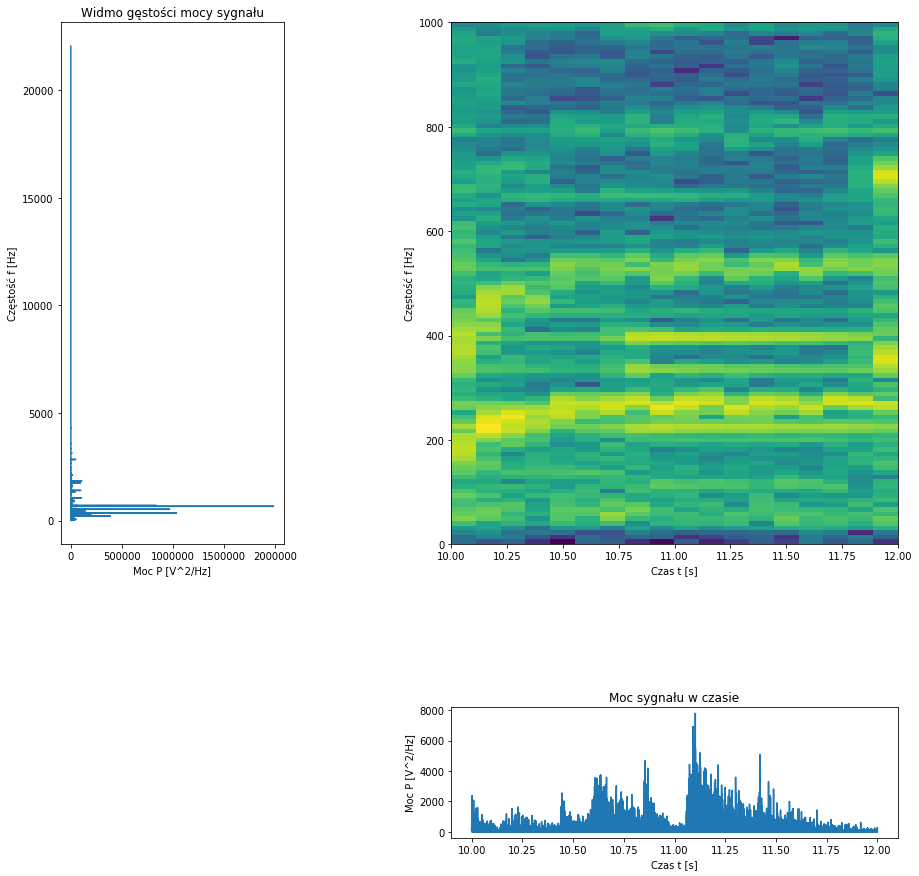

Długość okna: 5000
Długość sygnału: 88200
Stopień nachodzenia okienek: 0.5


In [99]:
N_okna2=5000
okno = ss.hamming(N_okna2)
t_min=10
t_max = 12
N_wsp2 = 0.5
spektrogram(signal2,okno_1 = okno,Fs = Fs2,N_okna = N_okna2,N_wsp = N_wsp2,f_max=1000,t_min=t_min,t_max=t_max)

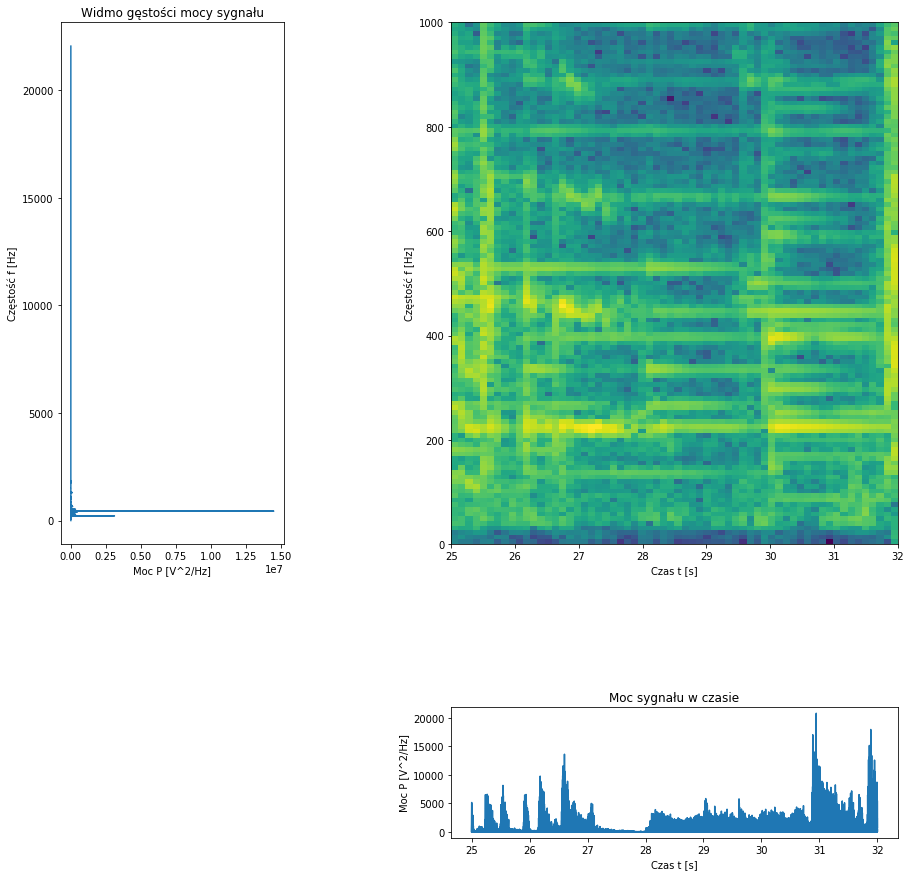

Długość okna: 5000
Długość sygnału: 308700
Stopień nachodzenia okienek: 0.5


In [100]:
N_okna2=5000
okno = ss.hamming(N_okna2)
t_min=25
t_max =32
N_wsp2 = 0.5
spektrogram(signal2,okno_1 = okno,Fs = Fs2,N_okna = N_okna2,N_wsp = N_wsp2,f_max=1000,t_min=t_min,t_max=t_max)

W pierwszym przypadku niestety nie jestem w stanie jednoznacznie wyróżnić tonów podstawowych - spekulowałabym, że wynoszą one około 180 Hz. W drugim przypadku powiedziałabym, że tony podstawowe wynoszą około 250 Hz, bo zauważamy 4 częstości harmoniczne rozłożone mniej więcej w równych odległościach. 